# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.


# Install detectron2

In [7]:
!python -m pip install pyyaml==5.1
!python -m pip install torch torchvision torchaudio
!python -m pip install opencv-python
!python -m pip install scikit-image
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

fatal: destination path 'detectron2' already exists and is not an empty directory.
^C
  Cloning https://github.com/facebookresearch/detectron2.git to /private/var/folders/y1/9bcvzg492znbq7qj0rhkdfp00000gn/T/pip-req-build-pul8eckb
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /private/var/folders/y1/9bcvzg492znbq7qj0rhkdfp00000gn/T/pip-req-build-pul8eckb
  Resolved https://github.com/facebookresearch/detectron2.git to commit dd2db71b0f8d855b71cac655186cbddca1bfda93
  Preparing metadata (setup.py) ... done


In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

zsh:1: command not found: nvcc
torch:  2.0 ; cuda:  2.0.1
detectron2: 0.6
matplotlib data path: /Users/andrijapaurevic/miniforge3/envs/detectron2/lib/python3.10/site-packages/matplotlib/mpl-data
CONFIGDIR=/Users/andrijapaurevic/.matplotlib
interactive is False
platform is darwin
CACHEDIR=/Users/andrijapaurevic/.matplotlib
Using fontManager instance from /Users/andrijapaurevic/.matplotlib/fontlist-v330.json
Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom dataset

# QFLOW 

In [13]:
# Double check this directory! Should be ./QuantumDotControl/autotuning/coarse_tuning/models/detectron2
ROOT_DIR = os.getcwd()
print(ROOT_DIR)

/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/models/Detectron_MRCNN


In [9]:
# download
!wget -nc https://data.nist.gov/od/ds/66492819760D3FF6E05324570681BA721894/data_qflow_lite.zip

# if this doesnt work, just go and download it and place it in ROOT_DIR

File ‘data_qflow_lite.zip’ already there; not retrieving.



In [ ]:
# Decompress data
!unzip data_qflow_lite.zip 

370875.56s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Archive:  data_qflow_lite.zip
replace __MACOSX/._data_qflow_lite? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [14]:
RAW_DATA_DIR = os.path.join(ROOT_DIR, "data_qflow_lite")
MODEL_DATA_DIR = os.path.join(ROOT_DIR, "csd")
MODEL_TRAIN_DATA_DIR = os.path.join(MODEL_DATA_DIR,"train")
MODEL_VAL_DATA_DIR = os.path.join(MODEL_DATA_DIR,"val")
os.mkdir(MODEL_DATA_DIR)
os.mkdir(MODEL_TRAIN_DATA_DIR)
os.mkdir(MODEL_VAL_DATA_DIR)

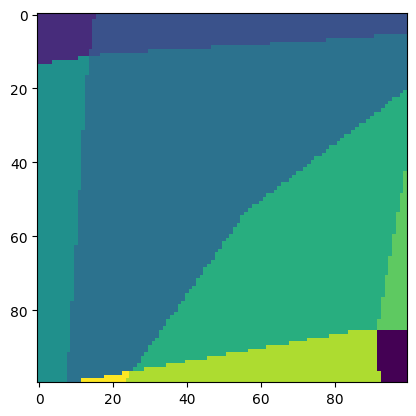

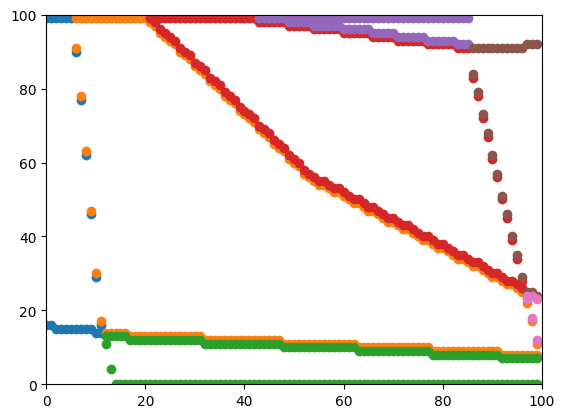

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [71]:
import os 
import skimage as sk
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# !python -m pip install alphashape
# !python -m pip install descartes

# import alphashape
# import matplotlib.pyplot as plt
# from descartes import PolygonPatch

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

class ProcessData():
    def __init__(self):
        self.vgg_format = {}

    def extract_csd(self, path_to_data, isTrain):
        qflow_data = np.load(path_to_data, allow_pickle=True).item()

        voltages = {"P1": qflow_data['V_P1_vec'], "P2": qflow_data['V_P2_vec']}
        dV = voltages["P1"][1] - voltages["P1"][0]

        N = len(voltages["P1"])
        M = len(voltages["P2"])
        
        assert N == M

        self.width, self.height = N,M
        self.fileID = os.path.basename(path_to_data).replace(".npy","")
        self.filename = self.fileID+".jpg"

        # Extract current, state regimes and gradient
        I = np.array([
            data['current'] for data in qflow_data['output']
        ]).reshape((N,N))

        grad = np.gradient(I, dV)
        dIdVP1, dIdVP2 = grad[0], grad[1]

        regimes = np.array([
            data['state'] for data in qflow_data['output']
        ]).reshape((N,N))

        def normalize(matrix):
            mean = matrix.mean()
            std = matrix.std()
            return (matrix - mean) / std

        I = normalize(dIdVP1)

        SAVE_DIR = MODEL_TRAIN_DATA_DIR if isTrain else MODEL_VAL_DATA_DIR

        from PIL import Image
        im = Image.fromarray(I.astype(np.uint8))
        SAVE_PATH = os.path.join(SAVE_DIR, '{}.jpg'.format(self.fileID))
        im.save(SAVE_PATH)

        csd = {"I": np.array(I,dtype=np.float32), "regimes": regimes}

        return csd
    
    def vgg_annotate_csd(self,csd):

        # First create a list of objects in the image
        object_list = []

        regimes = csd["regimes"]

        labelled_regimes = sk.measure.label(
            regimes, background = -1, connectivity = 1
        )
        
        fig, ax = plt.subplots()

        plt.imshow(labelled_regimes)
        plt.show()

        regions = sk.measure.regionprops(labelled_regimes)
        regions_list = []

        for index in range(1, labelled_regimes.max()):
            region_dict = {}


            region_coords = regions[index].coords

            result={}

            for row in region_coords:
                key = row[0]
                value = row[1]
                if key not in result:
                    result[key] = [value, value]  # Initialize with the current value
                else:
                    result[key][0] = min(result[key][0], value)  # Update minimum value
                    result[key][1] = max(result[key][1], value)  # Update maximum value

            output = np.array([[key, minmax[0]] for key, minmax in result.items()] + [[key, minmax[1]] for key, minmax in result.items()])

            x,y= output.T
            skip=1
            px = x.tolist()[::skip]
            py = y.tolist()[::skip]

            regime = regimes[int(np.average(y)), int(np.average(x))]
            
            patches = []
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            poly = np.array(poly).reshape(-1,2)
            # poly = sk.measure.approximate_polygon(poly)
            def organize_array_clockwise(arr):
                # Calculate the centroid of the points
                centroid = np.mean(arr, axis=0)

                # Calculate the angle of each point with respect to the centroid
                angles = np.arctan2(arr[:, 1] - centroid[1], arr[:, 0] - centroid[0])

                # Sort the points based on the angles in clockwise order
                indices = np.argsort(angles)
                sorted_arr = arr[indices]

                return sorted_arr


            poly = organize_array_clockwise(poly)
            # print(poly)
            patches.append(matplotlib.patches.Polygon(poly))
            p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)
            colors = 100*np.random.rand(len(patches))
            p.set_array(np.array(colors))
            ax.add_collection(p)
            ax.autoscale_view()
            plt.scatter(px,py)
            plt.xlim(0,100)
            plt.ylim(0,100)
            
            region_dict["shape_name"] = "polygon"
            region_dict["all_points_x"] = [row[0] for row in poly]
            region_dict["all_points_y"] = [row[1] for row in poly]

            # return
            if len(x.tolist()) <= 2 or len(y.tolist()) <=2:
                print("Ignoring", self.filename, len(x.tolist()), len(y.tolist()), " because their polygons too small for detectron2")
                return -1
            region_dict["class"] = regime

            regions_list.append(region_dict)
        plt.show()
        return

        object = {}
        object["filename"] = self.filename
        object["size"] = self.width * self.height
        object["regions"] = regions_list

        object_list.append(object)

        # Now create the VGG format
        
        for object in object_list:
             
            filename = object["filename"]
            size = object["size"]
            regions = object["regions"]

            self.vgg_format[self.fileID] = {}
            self.vgg_format[self.fileID]["filename"] = filename
            self.vgg_format[self.fileID]["size"] = size
            self.vgg_format[self.fileID]["regions"] = {}

            index = 0

            for region in regions:
                region_dict = {}
                shape_attributes = {}

                shape_attributes["name"] = region["shape_name"]
                shape_attributes["all_points_x"] = region["all_points_x"]
                shape_attributes["all_points_y"] = region["all_points_y"]

                region_dict["shape_attributes"] = shape_attributes
                region_dict["region_attributes"] = {"label": region["class"]}

                self.vgg_format[self.fileID]["regions"][str(index)] = region_dict

                index += 1

        self.vgg_format[self.fileID]["file_attributes"] = {}
        return 0 

    def dump_json(self,train_val_split, dataset_size, save_folder):
            num_of_train = int(train_val_split * dataset_size)
            keys, values = zip(*self.vgg_format.items())
            vgg_format_train = dict(zip(keys[:num_of_train], values[:num_of_train]))
            vgg_format_val = dict(zip(keys[num_of_train:], values[num_of_train:]))

            with open(save_folder+"/train/via_region_data.json", "w") as f:
                json.dump(vgg_format_train, f, cls=NumpyEncoder)
            with open(save_folder+"/val/via_region_data.json", "w") as f:
                json.dump(vgg_format_val, f, cls=NumpyEncoder)


ProcessData = ProcessData()
datapath = RAW_DATA_DIR
save_dir = MODEL_DATA_DIR
dataset_size = 500
train_val_split = 0.9
counter = 0
dataset = []
for filename in os.listdir(datapath):
      if filename.endswith(".npy"):
        if counter == dataset_size: 
            break

        csd = ProcessData.extract_csd(os.path.join(datapath,filename), isTrain=True if counter < dataset_size * (train_val_split) else False)
        result = ProcessData.vgg_annotate_csd(csd)

        dataset.append(csd)

        counter += 1 + result


ProcessData.dump_json(train_val_split, dataset_size, save_dir)

In [16]:
from detectron2.structures import BoxMode
def get_csd_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = 100, 100
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            regions = anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]

            
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": int(regions["label"]),
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

DatasetCatalog.clear()
MetadataCatalog.clear()

for d in ["train", "val"]:
    DatasetCatalog.register("csd_" + d, lambda d=d: get_csd_dicts("csd/" + d))
    MetadataCatalog.get("csd_" + d).set(thing_classes=["0","1","2"])
    MetadataCatalog.get("csd_" + d).set(thing_colors=[(255,0,0),(0,255,0),(0,0,255)])
csd_metadata = MetadataCatalog.get("csd_train")

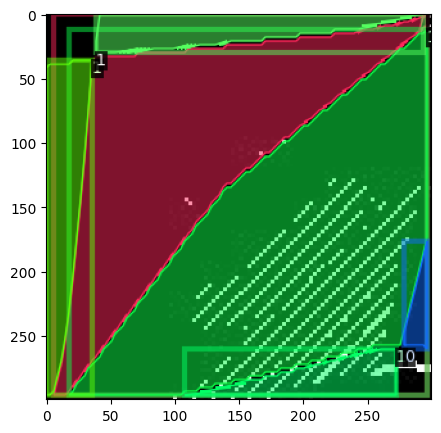

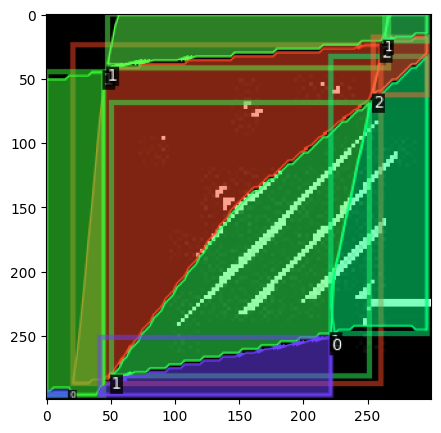

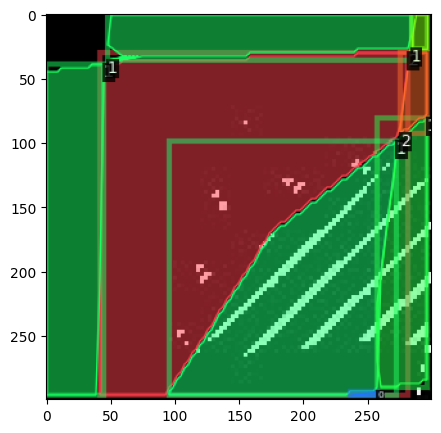

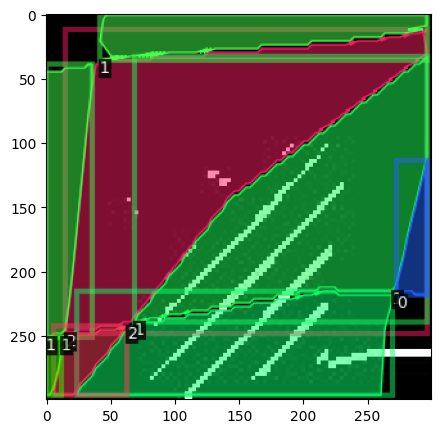

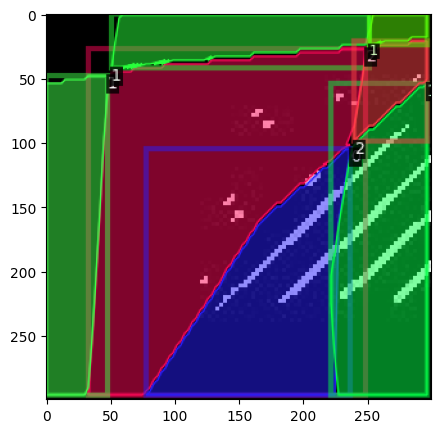

In [58]:
dataset_dicts = get_csd_dicts("csd/train")
# print(dataset_dicts)
# from detectron2.utils.visualizer import Visualizer
from PIL import Image
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import matplotlib.cm as cm
from matplotlib.pyplot import subplots
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=csd_metadata, scale=3, instance_mode=ColorMode.SEGMENTATION) #
    out = visualizer.draw_dataset_dict(d)
    fig, ax = subplots(figsize=(5, 5))
    ax.imshow(out.get_image()[:,:,::-1])

    # plt.imshow()
    # plt.show()

In [38]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("csd_train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.DEVICE = "cpu"

cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 5  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300 # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[06/06 18:37:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [78]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/07 12:09:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[Checkpointer] Loading from ./output/model_final.pth ...


All masks are false?:  False


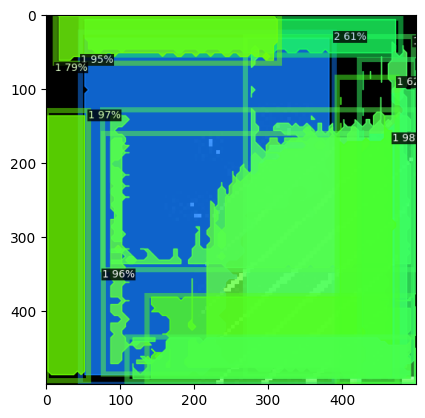

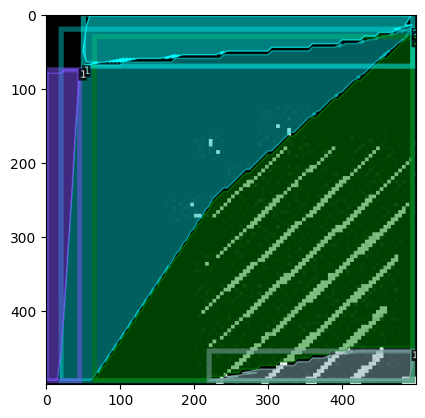

In [79]:

from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_csd_dicts("csd/val")
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    v = Visualizer(im[:, :, ::-1],
                   metadata=csd_metadata, 
                   scale=5,    # remove the colors of unsegmented pixels. This option is only available for segmentation models
                   instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels
    )
    
    print("All masks are false?: ", np.all(outputs["instances"].pred_masks.numpy()==False))


    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.show()
    
    plt.cla()
    plt.clf()
    plt.close()
    visualizer = Visualizer(im[:, :, ::-1], metadata=csd_metadata, scale=5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1],cmap=cm.summer)
    plt.show()


In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("csd_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "csd_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[06/06 17:29:12 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[06/06 17:29:12 d2.evaluation.coco_evaluation]: Trying to convert 'csd_val' to COCO format ...
[06/06 17:29:12 d2.data.datasets.coco]: Converting annotations of dataset 'csd_val' to COCO format ...)
[06/06 17:29:12 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/06 17:29:12 d2.data.datasets.coco]: Conversion finished, #images: 2, #annotations: 12
[06/06 17:29:12 d2.data.datasets.coco]: Caching COCO format annotations at './output/csd_val_coco_format.json' ...
[06/06 17:29:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/06 17:29:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/06 17:29:12 d2.data.common]: Serializing 2 elements to byte tensors and concatenating them all ...
[